## Importing Libs 

In [84]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
from models import *
from layers import *
from train import *
from test import *
from vision_dataloaders import *
from plots import *
from torchsummary import summary
from visualize import *
from diagnostics import *

## Load Data 

### Getting normalization values

In [7]:
tfm_names = ['tensor']

tfms = create_transform(tfm_names)

data = VisionData.load(tfms=tfms,train=True)

u,s=data.images.mean((0,1,2))/255,data.images.std((0,1,2))/255

Files already downloaded and verified


In [8]:
u,s

(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

In [9]:
tfm_names = ['normalize','tensor']


In [10]:
tfms = create_transform(tfm_names=tfm_names,norm_constants=(u,s))

In [11]:
tfms

Compose([
  Normalize(always_apply=False, p=1.0, mean=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784], max_pixel_value=255.0),
  ToTensor(always_apply=True, p=1.0, num_classes=1, sigmoid=True, normalize=None),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

In [12]:
data = VisionData.load(tfms=tfms,train=True)

Files already downloaded and verified


### Verifying our normalization


In [13]:
imgs=[]
for i in range(len(data)):
    imgs.append(data[i][0])

In [14]:
imgs = torch.stack(imgs)

In [15]:
imgs.mean((0,2,3)),imgs.std((0,2,3))

(tensor([ 4.1896e-08, -1.1749e-07,  5.8792e-08]),
 tensor([1.0000, 1.0000, 1.0000]))

### Trying augmentations 

In [16]:
aug_data = VisionData.load(name='CIFAR10')

Files already downloaded and verified


In [17]:
img=[aug_data.images[20]]*32

In [18]:
aug_data.images=np.array(img)

In [19]:
assert np.allclose(aug_data[0][0],aug_data[1][0])

In [20]:
#tfms = create_transform(tfm_names=['cutout','tensor'],angle=15,cutout_size=8,cutout_fillvalue=u)
tfms = create_transform(tfm_names=['normalize','cutout','tensor'],angle=15,cutout_size=16,cutout_fillvalue=u,norm_constants=(u,s),cutout_prob=0.75)

In [21]:
aug_data.tfms=tfms

In [22]:
tfms

Compose([
  Normalize(always_apply=False, p=1.0, mean=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784], max_pixel_value=255.0),
  Cutout(always_apply=False, p=0.75, num_holes=1, max_h_size=16, max_w_size=16),
  ToTensor(always_apply=True, p=1.0, num_classes=1, sigmoid=True, normalize=None),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

In [23]:
isCUDA = torch.cuda.is_available()
dev = torch.device('cuda') if isCUDA else torch.device('cpu')
dataloader_args = dict(shuffle=True,num_workers=4,batch_size = 8,pin_memory=True) if isCUDA else dict(shuffle=True,batch_size = 8//2)
dl=getDataLoader(aug_data,**dataloader_args)

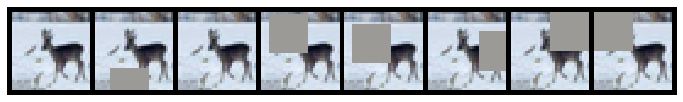

In [24]:
show_batch(dl)

### Defining DataLoaders

In [25]:
train_tfms = create_transform(tfm_names=['rotate','jitter','normalize','cutout','tensor'],norm_constant=(u,s),angle=15,cutout_size=16,
                        cutout_fillvalue=u,cutout_prob=0.75)
test_tfms = create_transform(tfm_names=['normalize','tensor'],norm_constant=(u,s))


train_data = VisionData.load(name='CIFAR10',tfms=train_tfms,train=True)
test_data = VisionData.load(name='CIFAR10',tfms=test_tfms,train=False)

train_dl,test_dl = getTrainTestLoader((train_data,test_data),BS=64)

Files already downloaded and verified
Files already downloaded and verified


## Model development 

In [ ]:
model = ResNet(drop=True,p=0.15).cuda()

In [ ]:
#model

In [ ]:
#summary(model,input_size=(3,32,32))

## Finding LR 

In [64]:
model1 = ResNet(drop=True,p=0.15).cuda()
opt1 = optim.SGD(model1.parameters(),lr=1e-3,momentum=0.9)
dls={}
dls['train']=train_dl
dls['valid']=test_dl
loss_func = nn.CrossEntropyLoss()
#sched = StepLR(opt,step_size=15,gamma=0.3)

In [65]:
finder = LRFinder(model1,opt1,loss_func)

In [66]:
finder.range_test(dls['train'],num_iter=200)

 96%|█████████▋| 193/200 [00:09<00:00, 20.29it/s]


Stopping early as the loss has started to diverge
Learning rate search is over. Please use self.plot to look at the graph


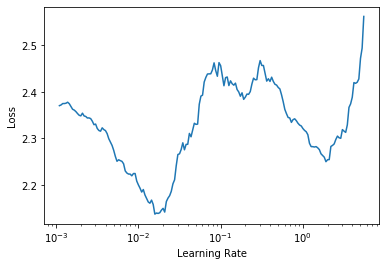

In [67]:
finder.plot(skip_start=0)

## Training Model 

In [26]:
model = ResNet(drop=True,p=0.15).cuda()
opt = optim.SGD(model.parameters(),lr=1e-2,momentum=0.9)
dls={}
dls['train']=train_dl
dls['valid']=test_dl
loss_func = nn.CrossEntropyLoss()
sched = get_scheduler(opt,'reduce',patience=5)

In [27]:
ldict = train(model,opt,dls,loss_func,50,scheduler=sched,device='cuda',sched_loss=True)

Training Loss:1.477, Training Acc:37.500: 100%|██████████| 782/782 [00:39<00:00, 20.03it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[0/50]--> Training Loss:1.616, Training Accuracy:41.424, Validation Loss:1.230, Validation Accuracy:58.250
Learning rate: 0.01


Training Loss:0.999, Training Acc:56.250: 100%|██████████| 782/782 [00:39<00:00, 19.92it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[1/50]--> Training Loss:1.194, Training Accuracy:57.614, Validation Loss:0.885, Validation Accuracy:69.450
Learning rate: 0.01


Training Loss:1.088, Training Acc:68.750: 100%|██████████| 782/782 [00:39<00:00, 19.86it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[2/50]--> Training Loss:0.999, Training Accuracy:64.532, Validation Loss:0.778, Validation Accuracy:73.340
Learning rate: 0.01


Training Loss:0.950, Training Acc:62.500: 100%|██████████| 782/782 [00:39<00:00, 19.82it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[3/50]--> Training Loss:0.881, Training Accuracy:69.090, Validation Loss:0.733, Validation Accuracy:75.680
Learning rate: 0.01


Training Loss:0.929, Training Acc:68.750: 100%|██████████| 782/782 [00:39<00:00, 19.81it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[4/50]--> Training Loss:0.805, Training Accuracy:72.046, Validation Loss:0.608, Validation Accuracy:79.190
Learning rate: 0.01


Training Loss:1.238, Training Acc:56.250: 100%|██████████| 782/782 [00:39<00:00, 19.77it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[5/50]--> Training Loss:0.744, Training Accuracy:73.898, Validation Loss:0.602, Validation Accuracy:80.000
Learning rate: 0.01


Training Loss:0.564, Training Acc:81.250: 100%|██████████| 782/782 [00:39<00:00, 19.78it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[6/50]--> Training Loss:0.686, Training Accuracy:76.024, Validation Loss:0.550, Validation Accuracy:81.140
Learning rate: 0.01


Training Loss:0.507, Training Acc:93.750: 100%|██████████| 782/782 [00:39<00:00, 19.77it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[7/50]--> Training Loss:0.651, Training Accuracy:77.176, Validation Loss:0.580, Validation Accuracy:80.790
Learning rate: 0.01


Training Loss:0.293, Training Acc:87.500: 100%|██████████| 782/782 [00:39<00:00, 19.79it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[8/50]--> Training Loss:0.617, Training Accuracy:78.418, Validation Loss:0.538, Validation Accuracy:82.200
Learning rate: 0.01


Training Loss:0.530, Training Acc:62.500: 100%|██████████| 782/782 [00:39<00:00, 19.76it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[9/50]--> Training Loss:0.582, Training Accuracy:79.500, Validation Loss:0.519, Validation Accuracy:83.700
Learning rate: 0.01


Training Loss:0.422, Training Acc:93.750: 100%|██████████| 782/782 [00:39<00:00, 19.79it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[10/50]--> Training Loss:0.549, Training Accuracy:80.704, Validation Loss:0.484, Validation Accuracy:84.140
Learning rate: 0.01


Training Loss:1.498, Training Acc:56.250: 100%|██████████| 782/782 [00:39<00:00, 19.72it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[11/50]--> Training Loss:0.530, Training Accuracy:81.230, Validation Loss:0.485, Validation Accuracy:84.280
Learning rate: 0.01


Training Loss:0.806, Training Acc:56.250: 100%|██████████| 782/782 [00:39<00:00, 19.79it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[12/50]--> Training Loss:0.505, Training Accuracy:82.088, Validation Loss:0.441, Validation Accuracy:85.340
Learning rate: 0.01


Training Loss:0.173, Training Acc:93.750: 100%|██████████| 782/782 [00:39<00:00, 19.75it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[13/50]--> Training Loss:0.483, Training Accuracy:83.030, Validation Loss:0.432, Validation Accuracy:85.590
Learning rate: 0.01


Training Loss:0.770, Training Acc:68.750: 100%|██████████| 782/782 [00:39<00:00, 19.82it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[14/50]--> Training Loss:0.457, Training Accuracy:83.996, Validation Loss:0.435, Validation Accuracy:86.000
Learning rate: 0.01


Training Loss:0.540, Training Acc:87.500: 100%|██████████| 782/782 [00:39<00:00, 19.78it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[15/50]--> Training Loss:0.437, Training Accuracy:84.516, Validation Loss:0.392, Validation Accuracy:87.060
Learning rate: 0.01


Training Loss:0.814, Training Acc:68.750: 100%|██████████| 782/782 [00:39<00:00, 19.77it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[16/50]--> Training Loss:0.419, Training Accuracy:85.270, Validation Loss:0.399, Validation Accuracy:87.270
Learning rate: 0.01


Training Loss:0.360, Training Acc:87.500: 100%|██████████| 782/782 [00:39<00:00, 19.97it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[17/50]--> Training Loss:0.406, Training Accuracy:85.806, Validation Loss:0.453, Validation Accuracy:85.500
Learning rate: 0.01


Training Loss:0.653, Training Acc:87.500: 100%|██████████| 782/782 [00:39<00:00, 19.76it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[18/50]--> Training Loss:0.391, Training Accuracy:86.154, Validation Loss:0.396, Validation Accuracy:87.240
Learning rate: 0.01


Training Loss:0.660, Training Acc:75.000: 100%|██████████| 782/782 [00:39<00:00, 19.77it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[19/50]--> Training Loss:0.374, Training Accuracy:86.906, Validation Loss:0.427, Validation Accuracy:86.820
Learning rate: 0.01


Training Loss:0.379, Training Acc:87.500: 100%|██████████| 782/782 [00:39<00:00, 19.77it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[20/50]--> Training Loss:0.366, Training Accuracy:86.996, Validation Loss:0.388, Validation Accuracy:87.480
Learning rate: 0.01


Training Loss:0.812, Training Acc:75.000: 100%|██████████| 782/782 [00:39<00:00, 19.75it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[21/50]--> Training Loss:0.347, Training Accuracy:87.798, Validation Loss:0.399, Validation Accuracy:87.980
Learning rate: 0.01


Training Loss:0.175, Training Acc:87.500: 100%|██████████| 782/782 [00:39<00:00, 19.72it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[22/50]--> Training Loss:0.337, Training Accuracy:88.106, Validation Loss:0.424, Validation Accuracy:87.740
Learning rate: 0.01


Training Loss:0.359, Training Acc:87.500: 100%|██████████| 782/782 [00:39<00:00, 19.74it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[23/50]--> Training Loss:0.318, Training Accuracy:88.758, Validation Loss:0.390, Validation Accuracy:88.050
Learning rate: 0.01


Training Loss:0.161, Training Acc:93.750: 100%|██████████| 782/782 [00:39<00:00, 19.79it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[24/50]--> Training Loss:0.316, Training Accuracy:88.910, Validation Loss:0.394, Validation Accuracy:87.730
Learning rate: 0.01


Training Loss:0.634, Training Acc:75.000: 100%|██████████| 782/782 [00:39<00:00, 19.74it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[25/50]--> Training Loss:0.312, Training Accuracy:89.028, Validation Loss:0.369, Validation Accuracy:88.770
Learning rate: 0.01


Training Loss:0.472, Training Acc:87.500: 100%|██████████| 782/782 [00:39<00:00, 19.73it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[26/50]--> Training Loss:0.291, Training Accuracy:89.684, Validation Loss:0.447, Validation Accuracy:86.660
Learning rate: 0.01


Training Loss:0.244, Training Acc:87.500: 100%|██████████| 782/782 [00:39<00:00, 19.70it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[27/50]--> Training Loss:0.288, Training Accuracy:89.908, Validation Loss:0.382, Validation Accuracy:88.430
Learning rate: 0.01


Training Loss:0.385, Training Acc:93.750: 100%|██████████| 782/782 [00:39<00:00, 19.71it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[28/50]--> Training Loss:0.278, Training Accuracy:90.252, Validation Loss:0.413, Validation Accuracy:87.940
Learning rate: 0.01


Training Loss:0.222, Training Acc:93.750: 100%|██████████| 782/782 [00:39<00:00, 19.75it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[29/50]--> Training Loss:0.269, Training Accuracy:90.526, Validation Loss:0.359, Validation Accuracy:89.310
Learning rate: 0.01


Training Loss:0.206, Training Acc:93.750: 100%|██████████| 782/782 [00:39<00:00, 19.92it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[30/50]--> Training Loss:0.260, Training Accuracy:90.864, Validation Loss:0.368, Validation Accuracy:89.400
Learning rate: 0.01


Training Loss:0.170, Training Acc:93.750: 100%|██████████| 782/782 [00:39<00:00, 19.86it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[31/50]--> Training Loss:0.258, Training Accuracy:90.840, Validation Loss:0.377, Validation Accuracy:89.070
Learning rate: 0.01


Training Loss:0.736, Training Acc:87.500: 100%|██████████| 782/782 [00:39<00:00, 19.76it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[32/50]--> Training Loss:0.245, Training Accuracy:91.326, Validation Loss:0.390, Validation Accuracy:89.100
Learning rate: 0.01


Training Loss:0.104, Training Acc:100.000: 100%|██████████| 782/782 [00:39<00:00, 19.77it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[33/50]--> Training Loss:0.240, Training Accuracy:91.496, Validation Loss:0.378, Validation Accuracy:89.190
Learning rate: 0.01


Training Loss:0.272, Training Acc:87.500: 100%|██████████| 782/782 [00:39<00:00, 19.76it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[34/50]--> Training Loss:0.240, Training Accuracy:91.466, Validation Loss:0.385, Validation Accuracy:89.350
Learning rate: 0.01


Training Loss:0.301, Training Acc:87.500: 100%|██████████| 782/782 [00:39<00:00, 19.76it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[35/50]--> Training Loss:0.228, Training Accuracy:91.886, Validation Loss:0.379, Validation Accuracy:89.300
Learning rate: 0.001


Training Loss:0.046, Training Acc:100.000: 100%|██████████| 782/782 [00:39<00:00, 19.77it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[36/50]--> Training Loss:0.176, Training Accuracy:93.932, Validation Loss:0.330, Validation Accuracy:90.670
Learning rate: 0.001


Training Loss:0.098, Training Acc:100.000: 100%|██████████| 782/782 [00:39<00:00, 19.83it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[37/50]--> Training Loss:0.155, Training Accuracy:94.606, Validation Loss:0.331, Validation Accuracy:90.680
Learning rate: 0.001


Training Loss:0.062, Training Acc:100.000: 100%|██████████| 782/782 [00:39<00:00, 19.76it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[38/50]--> Training Loss:0.153, Training Accuracy:94.688, Validation Loss:0.325, Validation Accuracy:90.780
Learning rate: 0.001


Training Loss:0.050, Training Acc:100.000: 100%|██████████| 782/782 [00:39<00:00, 19.71it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[39/50]--> Training Loss:0.146, Training Accuracy:94.946, Validation Loss:0.330, Validation Accuracy:90.730
Learning rate: 0.001


Training Loss:0.053, Training Acc:100.000: 100%|██████████| 782/782 [00:39<00:00, 19.79it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[40/50]--> Training Loss:0.142, Training Accuracy:95.062, Validation Loss:0.334, Validation Accuracy:90.810
Learning rate: 0.001


Training Loss:0.354, Training Acc:93.750: 100%|██████████| 782/782 [00:39<00:00, 19.74it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[41/50]--> Training Loss:0.139, Training Accuracy:95.256, Validation Loss:0.334, Validation Accuracy:90.950
Learning rate: 0.001


Training Loss:0.043, Training Acc:100.000: 100%|██████████| 782/782 [00:39<00:00, 19.76it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[42/50]--> Training Loss:0.138, Training Accuracy:95.206, Validation Loss:0.335, Validation Accuracy:90.900
Learning rate: 0.001


Training Loss:0.198, Training Acc:93.750: 100%|██████████| 782/782 [00:39<00:00, 19.73it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[43/50]--> Training Loss:0.134, Training Accuracy:95.256, Validation Loss:0.335, Validation Accuracy:91.020
Learning rate: 0.001


Training Loss:0.140, Training Acc:93.750: 100%|██████████| 782/782 [00:39<00:00, 19.78it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[44/50]--> Training Loss:0.131, Training Accuracy:95.490, Validation Loss:0.335, Validation Accuracy:90.970
Learning rate: 0.0001


Training Loss:0.129, Training Acc:93.750: 100%|██████████| 782/782 [00:39<00:00, 19.75it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[45/50]--> Training Loss:0.132, Training Accuracy:95.466, Validation Loss:0.334, Validation Accuracy:91.040
Learning rate: 0.0001


Training Loss:0.168, Training Acc:93.750: 100%|██████████| 782/782 [00:39<00:00, 19.68it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[46/50]--> Training Loss:0.129, Training Accuracy:95.452, Validation Loss:0.329, Validation Accuracy:90.970
Learning rate: 0.0001


Training Loss:0.106, Training Acc:93.750: 100%|██████████| 782/782 [00:39<00:00, 19.85it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[47/50]--> Training Loss:0.128, Training Accuracy:95.398, Validation Loss:0.327, Validation Accuracy:91.040
Learning rate: 0.0001


Training Loss:0.217, Training Acc:93.750: 100%|██████████| 782/782 [00:39<00:00, 19.77it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[48/50]--> Training Loss:0.126, Training Accuracy:95.670, Validation Loss:0.332, Validation Accuracy:91.030
Learning rate: 0.0001


Training Loss:0.417, Training Acc:87.500: 100%|██████████| 782/782 [00:39<00:00, 19.95it/s] 



[49/50]--> Training Loss:0.128, Training Accuracy:95.540, Validation Loss:0.329, Validation Accuracy:91.030
Learning rate: 0.0001


In [28]:
model = ResNet(drop=False,p=0.15).cuda()
opt = optim.SGD(model.parameters(),lr=1e-2,momentum=0.9)
dls={}
dls['train']=train_dl
dls['valid']=test_dl
loss_func = nn.CrossEntropyLoss()
sched = get_scheduler(opt,'reduce')

In [29]:
ldict = train(model,opt,dls,loss_func,50,scheduler=sched,device='cuda',sched_loss=True)

Training Loss:1.301, Training Acc:43.750: 100%|██████████| 782/782 [00:37<00:00, 21.04it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[0/50]--> Training Loss:1.504, Training Accuracy:45.256, Validation Loss:1.183, Validation Accuracy:60.130
Learning rate: 0.01


Training Loss:1.390, Training Acc:50.000: 100%|██████████| 782/782 [00:37<00:00, 20.92it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[1/50]--> Training Loss:1.048, Training Accuracy:62.940, Validation Loss:0.888, Validation Accuracy:69.430
Learning rate: 0.01


Training Loss:1.095, Training Acc:62.500: 100%|██████████| 782/782 [00:37<00:00, 20.93it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[2/50]--> Training Loss:0.858, Training Accuracy:70.002, Validation Loss:0.703, Validation Accuracy:76.140
Learning rate: 0.01


Training Loss:0.291, Training Acc:87.500: 100%|██████████| 782/782 [00:37<00:00, 20.86it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[3/50]--> Training Loss:0.740, Training Accuracy:74.214, Validation Loss:0.680, Validation Accuracy:77.370
Learning rate: 0.01


Training Loss:0.506, Training Acc:81.250: 100%|██████████| 782/782 [00:37<00:00, 20.92it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[4/50]--> Training Loss:0.660, Training Accuracy:77.116, Validation Loss:0.597, Validation Accuracy:80.300
Learning rate: 0.01


Training Loss:0.806, Training Acc:81.250: 100%|██████████| 782/782 [00:37<00:00, 20.88it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[5/50]--> Training Loss:0.597, Training Accuracy:79.058, Validation Loss:0.589, Validation Accuracy:80.790
Learning rate: 0.01


Training Loss:0.399, Training Acc:87.500: 100%|██████████| 782/782 [00:37<00:00, 20.92it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[6/50]--> Training Loss:0.543, Training Accuracy:80.980, Validation Loss:0.492, Validation Accuracy:83.730
Learning rate: 0.01


Training Loss:0.436, Training Acc:93.750: 100%|██████████| 782/782 [00:37<00:00, 20.92it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[7/50]--> Training Loss:0.494, Training Accuracy:82.494, Validation Loss:0.502, Validation Accuracy:83.820
Learning rate: 0.01


Training Loss:0.343, Training Acc:81.250: 100%|██████████| 782/782 [00:36<00:00, 21.24it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[8/50]--> Training Loss:0.456, Training Accuracy:83.942, Validation Loss:0.481, Validation Accuracy:84.280
Learning rate: 0.01


Training Loss:0.515, Training Acc:87.500: 100%|██████████| 782/782 [00:37<00:00, 20.88it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[9/50]--> Training Loss:0.424, Training Accuracy:85.120, Validation Loss:0.501, Validation Accuracy:83.790
Learning rate: 0.01


Training Loss:0.106, Training Acc:100.000: 100%|██████████| 782/782 [00:37<00:00, 20.87it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[10/50]--> Training Loss:0.390, Training Accuracy:86.214, Validation Loss:0.495, Validation Accuracy:84.470
Learning rate: 0.01


Training Loss:0.196, Training Acc:100.000: 100%|██████████| 782/782 [00:37<00:00, 20.86it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[11/50]--> Training Loss:0.361, Training Accuracy:87.378, Validation Loss:0.458, Validation Accuracy:85.880
Learning rate: 0.01


Training Loss:1.045, Training Acc:68.750: 100%|██████████| 782/782 [00:37<00:00, 20.98it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[12/50]--> Training Loss:0.333, Training Accuracy:88.162, Validation Loss:0.498, Validation Accuracy:85.330
Learning rate: 0.01


Training Loss:0.517, Training Acc:81.250: 100%|██████████| 782/782 [00:37<00:00, 20.87it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[13/50]--> Training Loss:0.324, Training Accuracy:88.784, Validation Loss:0.516, Validation Accuracy:85.560
Learning rate: 0.01


Training Loss:0.509, Training Acc:75.000: 100%|██████████| 782/782 [00:37<00:00, 20.87it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[14/50]--> Training Loss:0.298, Training Accuracy:89.584, Validation Loss:0.453, Validation Accuracy:86.410
Learning rate: 0.01


Training Loss:0.082, Training Acc:100.000: 100%|██████████| 782/782 [00:37<00:00, 20.87it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[15/50]--> Training Loss:0.282, Training Accuracy:90.056, Validation Loss:0.471, Validation Accuracy:86.260
Learning rate: 0.01


Training Loss:0.147, Training Acc:93.750: 100%|██████████| 782/782 [00:36<00:00, 21.19it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[16/50]--> Training Loss:0.267, Training Accuracy:90.666, Validation Loss:0.451, Validation Accuracy:86.480
Learning rate: 0.01


Training Loss:0.047, Training Acc:100.000: 100%|██████████| 782/782 [00:37<00:00, 20.89it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[17/50]--> Training Loss:0.246, Training Accuracy:91.332, Validation Loss:0.468, Validation Accuracy:87.000
Learning rate: 0.01


Training Loss:0.429, Training Acc:81.250: 100%|██████████| 782/782 [00:37<00:00, 20.91it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[18/50]--> Training Loss:0.235, Training Accuracy:91.762, Validation Loss:0.480, Validation Accuracy:86.040
Learning rate: 0.01


Training Loss:0.450, Training Acc:93.750: 100%|██████████| 782/782 [00:37<00:00, 20.87it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[19/50]--> Training Loss:0.220, Training Accuracy:92.370, Validation Loss:0.443, Validation Accuracy:88.190
Learning rate: 0.01


Training Loss:0.445, Training Acc:87.500: 100%|██████████| 782/782 [00:37<00:00, 20.95it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[20/50]--> Training Loss:0.209, Training Accuracy:92.666, Validation Loss:0.435, Validation Accuracy:88.310
Learning rate: 0.01


Training Loss:0.063, Training Acc:100.000: 100%|██████████| 782/782 [00:37<00:00, 20.91it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[21/50]--> Training Loss:0.198, Training Accuracy:93.156, Validation Loss:0.463, Validation Accuracy:87.760
Learning rate: 0.01


Training Loss:0.019, Training Acc:100.000: 100%|██████████| 782/782 [00:37<00:00, 20.95it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[22/50]--> Training Loss:0.185, Training Accuracy:93.562, Validation Loss:0.467, Validation Accuracy:87.630
Learning rate: 0.01


Training Loss:0.043, Training Acc:100.000: 100%|██████████| 782/782 [00:37<00:00, 20.87it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[23/50]--> Training Loss:0.178, Training Accuracy:93.710, Validation Loss:0.473, Validation Accuracy:87.730
Learning rate: 0.01


Training Loss:0.456, Training Acc:87.500: 100%|██████████| 782/782 [00:37<00:00, 20.88it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[24/50]--> Training Loss:0.171, Training Accuracy:93.976, Validation Loss:0.521, Validation Accuracy:87.480
Learning rate: 0.01


Training Loss:0.059, Training Acc:93.750: 100%|██████████| 782/782 [00:37<00:00, 20.92it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[25/50]--> Training Loss:0.168, Training Accuracy:94.104, Validation Loss:0.511, Validation Accuracy:87.170
Learning rate: 0.01


Training Loss:0.160, Training Acc:93.750: 100%|██████████| 782/782 [00:37<00:00, 21.00it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[26/50]--> Training Loss:0.170, Training Accuracy:94.132, Validation Loss:0.450, Validation Accuracy:88.520
Learning rate: 0.01


Training Loss:0.094, Training Acc:93.750: 100%|██████████| 782/782 [00:37<00:00, 20.95it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[27/50]--> Training Loss:0.158, Training Accuracy:94.670, Validation Loss:0.530, Validation Accuracy:87.000
Learning rate: 0.01


Training Loss:0.078, Training Acc:100.000: 100%|██████████| 782/782 [00:37<00:00, 20.84it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[28/50]--> Training Loss:0.151, Training Accuracy:94.736, Validation Loss:0.487, Validation Accuracy:87.770
Learning rate: 0.01


Training Loss:0.046, Training Acc:100.000: 100%|██████████| 782/782 [00:37<00:00, 20.89it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[29/50]--> Training Loss:0.150, Training Accuracy:94.766, Validation Loss:0.439, Validation Accuracy:88.820
Learning rate: 0.01


Training Loss:0.243, Training Acc:93.750: 100%|██████████| 782/782 [00:37<00:00, 21.08it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[30/50]--> Training Loss:0.137, Training Accuracy:95.288, Validation Loss:0.570, Validation Accuracy:86.820
Learning rate: 0.01


Training Loss:0.102, Training Acc:93.750: 100%|██████████| 782/782 [00:37<00:00, 20.88it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[31/50]--> Training Loss:0.136, Training Accuracy:95.252, Validation Loss:0.509, Validation Accuracy:87.840
Learning rate: 0.001


Training Loss:0.043, Training Acc:100.000: 100%|██████████| 782/782 [00:37<00:00, 20.90it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[32/50]--> Training Loss:0.103, Training Accuracy:96.492, Validation Loss:0.397, Validation Accuracy:90.000
Learning rate: 0.001


Training Loss:0.085, Training Acc:100.000: 100%|██████████| 782/782 [00:37<00:00, 20.92it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[33/50]--> Training Loss:0.083, Training Accuracy:97.210, Validation Loss:0.401, Validation Accuracy:90.010
Learning rate: 0.001


Training Loss:0.044, Training Acc:100.000: 100%|██████████| 782/782 [00:37<00:00, 20.86it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[34/50]--> Training Loss:0.077, Training Accuracy:97.426, Validation Loss:0.394, Validation Accuracy:90.240
Learning rate: 0.001


Training Loss:0.017, Training Acc:100.000: 100%|██████████| 782/782 [00:37<00:00, 20.95it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[35/50]--> Training Loss:0.072, Training Accuracy:97.604, Validation Loss:0.397, Validation Accuracy:89.990
Learning rate: 0.001


Training Loss:0.044, Training Acc:100.000: 100%|██████████| 782/782 [00:37<00:00, 20.94it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[36/50]--> Training Loss:0.068, Training Accuracy:97.712, Validation Loss:0.390, Validation Accuracy:90.200
Learning rate: 0.001


Training Loss:0.113, Training Acc:93.750: 100%|██████████| 782/782 [00:37<00:00, 20.90it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[37/50]--> Training Loss:0.065, Training Accuracy:97.792, Validation Loss:0.396, Validation Accuracy:90.420
Learning rate: 0.001


Training Loss:0.235, Training Acc:93.750: 100%|██████████| 782/782 [00:37<00:00, 20.90it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[38/50]--> Training Loss:0.062, Training Accuracy:97.902, Validation Loss:0.401, Validation Accuracy:90.270
Learning rate: 0.001


Training Loss:0.062, Training Acc:100.000: 100%|██████████| 782/782 [00:37<00:00, 20.92it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[39/50]--> Training Loss:0.062, Training Accuracy:97.940, Validation Loss:0.394, Validation Accuracy:90.370
Learning rate: 0.001


Training Loss:0.015, Training Acc:100.000: 100%|██████████| 782/782 [00:37<00:00, 20.90it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[40/50]--> Training Loss:0.060, Training Accuracy:97.978, Validation Loss:0.394, Validation Accuracy:90.620
Learning rate: 0.001


Training Loss:0.149, Training Acc:93.750: 100%|██████████| 782/782 [00:37<00:00, 20.88it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[41/50]--> Training Loss:0.058, Training Accuracy:98.026, Validation Loss:0.396, Validation Accuracy:90.510
Learning rate: 0.001


Training Loss:0.175, Training Acc:87.500: 100%|██████████| 782/782 [00:37<00:00, 20.91it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[42/50]--> Training Loss:0.059, Training Accuracy:98.024, Validation Loss:0.403, Validation Accuracy:90.350
Learning rate: 0.001


Training Loss:0.403, Training Acc:93.750: 100%|██████████| 782/782 [00:37<00:00, 20.98it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[43/50]--> Training Loss:0.057, Training Accuracy:98.048, Validation Loss:0.399, Validation Accuracy:90.370
Learning rate: 0.001


Training Loss:0.009, Training Acc:100.000: 100%|██████████| 782/782 [00:37<00:00, 20.91it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[44/50]--> Training Loss:0.055, Training Accuracy:98.176, Validation Loss:0.403, Validation Accuracy:90.400
Learning rate: 0.001


Training Loss:0.674, Training Acc:87.500: 100%|██████████| 782/782 [00:37<00:00, 20.82it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[45/50]--> Training Loss:0.055, Training Accuracy:98.200, Validation Loss:0.404, Validation Accuracy:90.380
Learning rate: 0.001


Training Loss:0.091, Training Acc:93.750: 100%|██████████| 782/782 [00:37<00:00, 20.81it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[46/50]--> Training Loss:0.052, Training Accuracy:98.252, Validation Loss:0.404, Validation Accuracy:90.220
Learning rate: 0.001


Training Loss:0.050, Training Acc:93.750: 100%|██████████| 782/782 [00:37<00:00, 20.90it/s] 


  0%|          | 0/782 [00:00<?, ?it/s]


[47/50]--> Training Loss:0.053, Training Accuracy:98.208, Validation Loss:0.409, Validation Accuracy:90.470
Learning rate: 0.0001


Training Loss:0.075, Training Acc:100.000: 100%|██████████| 782/782 [00:37<00:00, 20.94it/s]


  0%|          | 0/782 [00:00<?, ?it/s]


[48/50]--> Training Loss:0.053, Training Accuracy:98.182, Validation Loss:0.405, Validation Accuracy:90.520
Learning rate: 0.0001


Training Loss:0.011, Training Acc:100.000: 100%|██████████| 782/782 [00:37<00:00, 20.84it/s]



[49/50]--> Training Loss:0.051, Training Accuracy:98.236, Validation Loss:0.395, Validation Accuracy:90.590
Learning rate: 0.0001


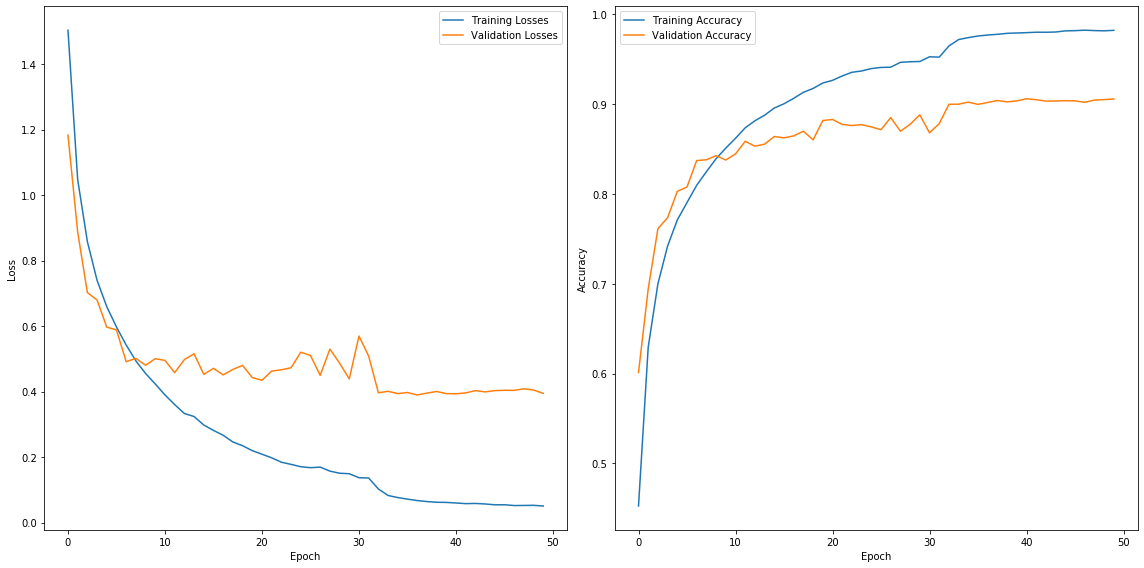

In [30]:
plot_diagnostics(ldict)

In [60]:
test_res=test(model,test_dl,loss_func,device='cuda')

In [61]:
test_res

{'Loss': 0.3948633490562439, 'Accuracy': 90.59}

In [34]:
torch.save(model.state_dict(),'model_88')

## GradCAM 

In [35]:
gradcam = GradCAM(model.to('cpu'),norm_constants=(u,s))

100%|██████████| 79/79 [00:32<00:00,  2.45it/s]


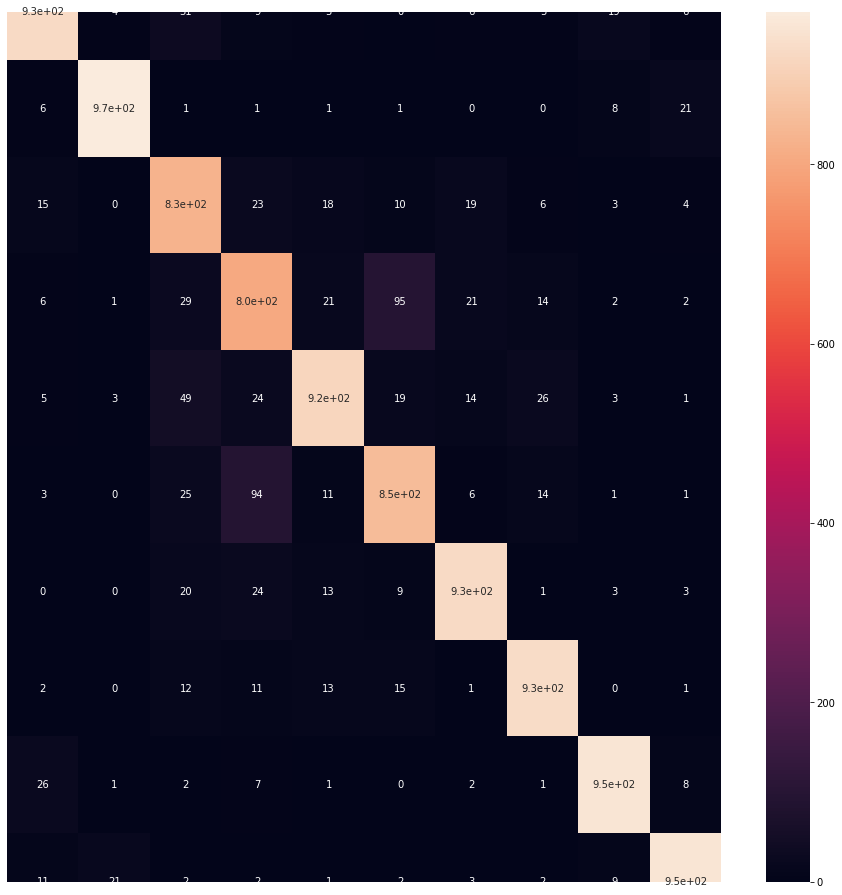

In [78]:
cm = show_matrix(model,test_dl)

In [82]:
incorr = get_random_incorrects(model,test_dl)

100%|██████████| 79/79 [00:33<00:00,  2.38it/s]


In [89]:
gradcam = GradCAM(model.to('cpu'),norm_constants=(u,s))

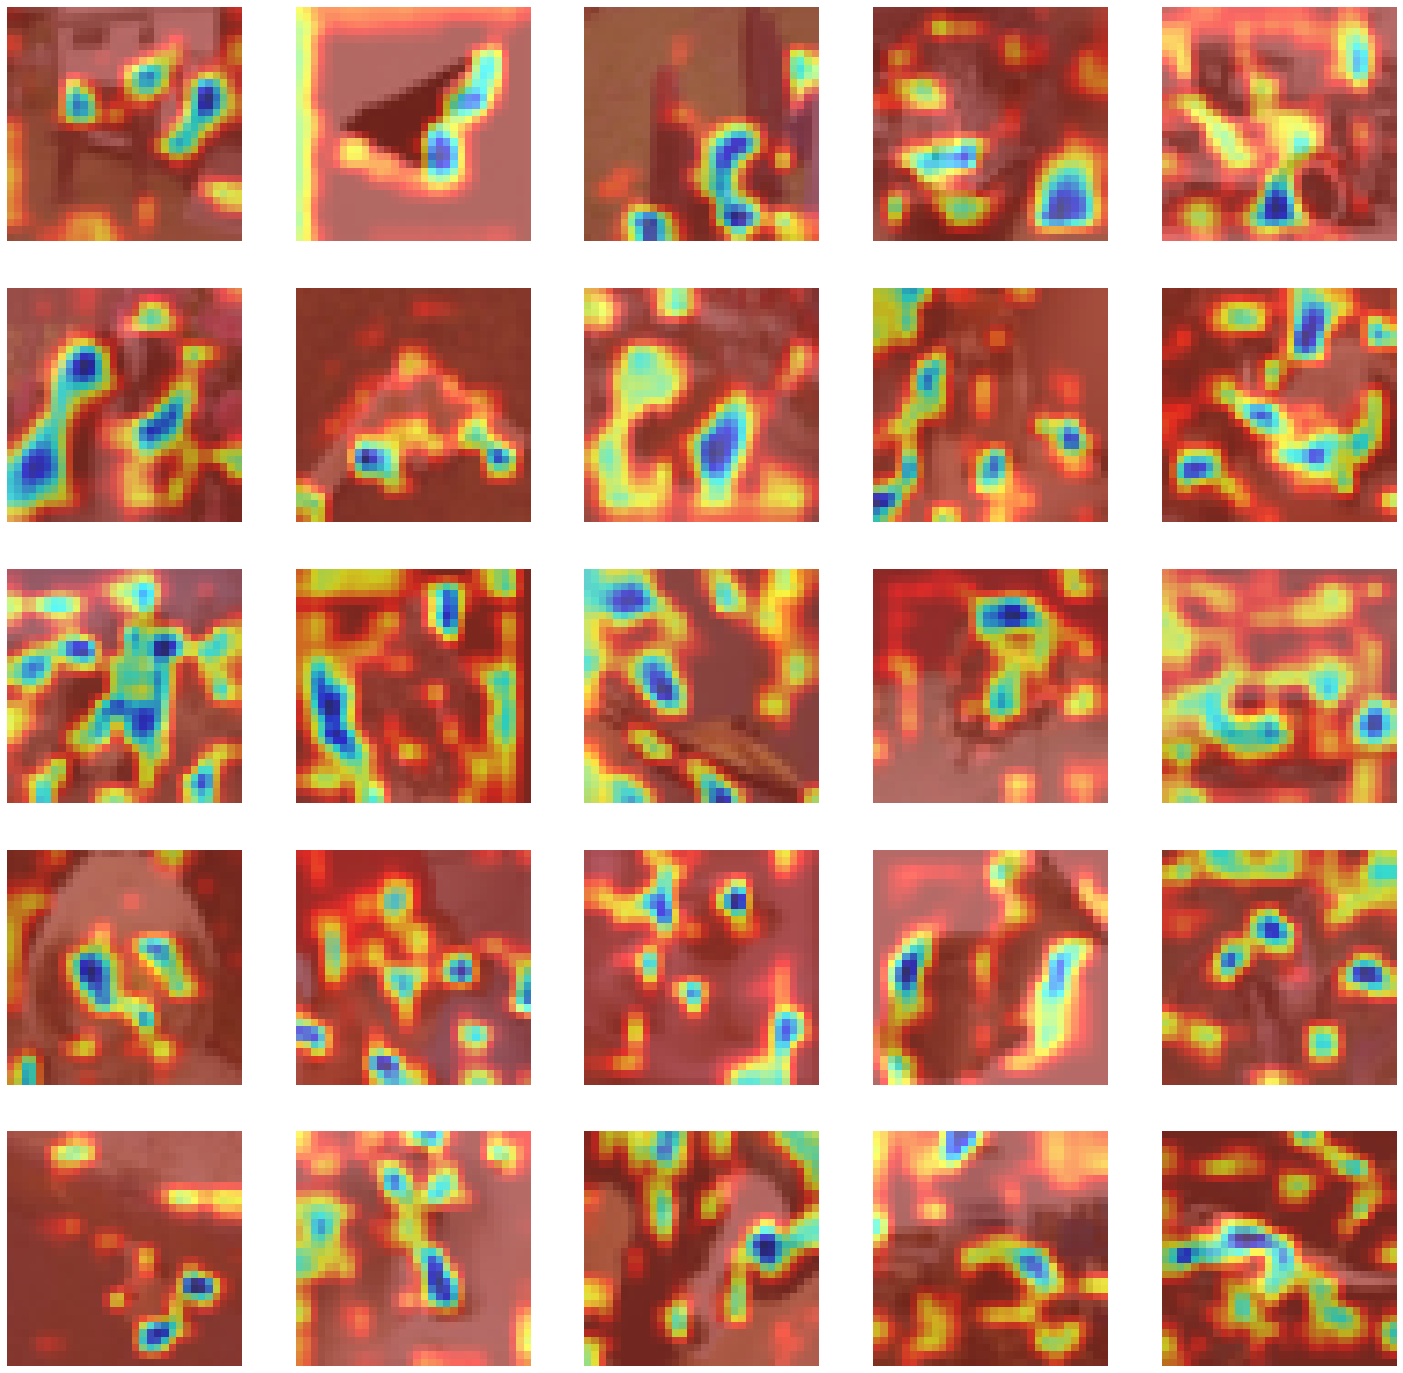

In [90]:
fig,axs = plt.subplots(5,5,figsize=(25,25))
for ax,idx in zip(axs.ravel(),incorr[:25]):
    img = test_data.tfms(image=test_data.images[idx])["image"].unsqueeze(0)
    label = train_data.labels[idx]
    _=gradcam(img,'net.2.1.conv.1.lyrs.1',label,show=True,ax=ax)